# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We extend the model from before to:

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(0.5, 0.5) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right) \right) \\
\end{align}

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import edward2 as ed

In [3]:
from sklearn import preprocessing

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Exp

## Simulated data

In [5]:
seed = 42
np.random.seed(seed)

In [6]:
conditions = ["C" + str(i) for i in range(2)]
genes = ["G" + str(i) for i in range(2)]
sgrnas = ["S" + str(i) for i in range(2)]
replicates = ["R" + str(i) for i in range(2)]

In [7]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [8]:
combinations

[('G0', 'C0', 'S0', 'R0'),
 ('G0', 'C0', 'S0', 'R1'),
 ('G0', 'C0', 'S1', 'R0'),
 ('G0', 'C0', 'S1', 'R1'),
 ('G0', 'C1', 'S0', 'R0'),
 ('G0', 'C1', 'S0', 'R1'),
 ('G0', 'C1', 'S1', 'R0'),
 ('G0', 'C1', 'S1', 'R1'),
 ('G1', 'C0', 'S0', 'R0'),
 ('G1', 'C0', 'S0', 'R1'),
 ('G1', 'C0', 'S1', 'R0'),
 ('G1', 'C0', 'S1', 'R1'),
 ('G1', 'C1', 'S0', 'R0'),
 ('G1', 'C1', 'S0', 'R1'),
 ('G1', 'C1', 'S1', 'R0'),
 ('G1', 'C1', 'S1', 'R1')]

In [9]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [10]:
sgrna_ids = np.repeat(["S" + str(i) for i in range(len(genes) * len(conditions) * len(sgrnas))], 2)
sgrna_ids

array(['S0', 'S0', 'S1', 'S1', 'S2', 'S2', 'S3', 'S3', 'S4', 'S4', 'S5',
       'S5', 'S6', 'S6', 'S7', 'S7'], dtype='<U2')

In [11]:
condition_ids = np.repeat(["C" + str(i) for i in range(len(genes) * len(conditions))], 4)
condition_ids

array(['C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2',
       'C2', 'C3', 'C3', 'C3', 'C3'], dtype='<U2')

In [12]:
count_table.sgrnas = sgrna_ids
count_table.conditions = condition_ids

In [13]:
count_table

,genes,conditions,sgrnas,replicates
0,G0,C0,S0,R0
1,G0,C0,S0,R1
2,G0,C0,S1,R0
3,G0,C0,S1,R1
4,G0,C1,S2,R0
5,G0,C1,S2,R1
6,G0,C1,S3,R0
7,G0,C1,S3,R1
8,G1,C2,S4,R0
9,G1,C2,S4,R1


In [14]:
tau_true = sp.stats.halfcauchy.rvs(0, .1, size=1)
tau_true

array([0.06671342])

In [15]:
gamma_true = sp.array([.6, 6])
gamma_true

array([0.6, 6. ])

In [16]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([0.52582267, 0.62127506, 6.0186158 , 6.06741494])

In [17]:
l_true = sp.stats.norm.rvs(0, .1, size= len(conditions) * len(genes) * len(sgrnas))
l_true

array([-0.05808781, -0.05251698, -0.05713802, -0.09240828, -0.2612549 ,
        0.09503697,  0.08164451, -0.1523876 ])

In [18]:
l_idx = np.repeat(range(len(l_true)), len(replicates))
l_idx

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [19]:
beta_idx = np.repeat(range(len(beta_true)),
                     len(sgrnas) * len(replicates))
beta_idx

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [20]:
counts = sp.stats.poisson.rvs(
    np.exp(beta_true[beta_idx] + l_true[l_idx]))
counts

array([  0,   1,   2,   2,   1,   0,   4,   2, 316, 345, 462, 453, 500,
       506, 352, 361])

## Model

In [21]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

## Test 1

In [75]:
n = 10000
var = tfd.Normal(1, 1).sample(n)
with tf.Session() as sess:
    v = sess.run(var)

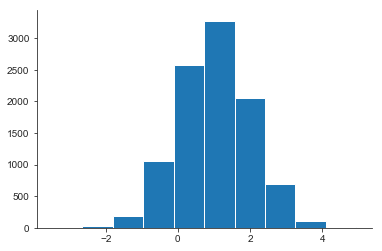

In [78]:
plt.hist(v);

In [79]:
def easy_model(size):
    gamma_tau = ed.InverseGamma(5, 1, name="gamma_tau")
    gamma = ed.Normal(1, 5, name="gamma")   
    x = ed.Normal(tf.ones(size) * gamma, 1, name="x")
    return x

log_joint = ed.make_log_joint_fn(easy_model)

In [80]:
def target_log_prob_fn(gamma_tau, gamma):
    return log_joint(
        size=len(v),        
        gamma_tau=gamma_tau,
        gamma=gamma,        
        x=v)

In [41]:
tf.reset_default_graph()
step_size = tf.get_variable(name='step_size', initializer=1., use_resource=True)

In [42]:
num_results = int(10e3)
num_burnin_steps = int(1e3)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros([], name='gamma')
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=3000),
        num_leapfrog_steps=5));

/home/simon/miniconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [82]:
num_results = 100000
num_burnin_steps = 100000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros([], name='gamma')
    ],
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=target_log_prob_fn));

In [83]:
init_op = tf.global_variables_initializer()

In [97]:
with tf.Session() as sess:
    init_op.run()
    states_, is_accepted_, = sess.run([states, kernel_results.is_accepted])

In [99]:
states_

[array([0.43423843, 0.43423843, 0.43423843, ..., 0.4460097 , 0.4460097 ,
        0.4460097 ], dtype=float32),
 array([1.0188668, 1.0188668, 1.0188668, ..., 1.0231538, 1.0231538,
        1.0231538], dtype=float32)]

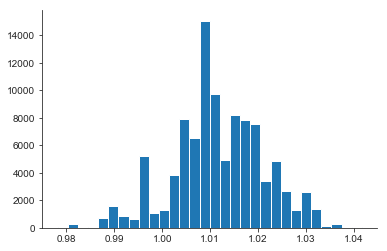

In [90]:
plt.hist(g_, bins=30);

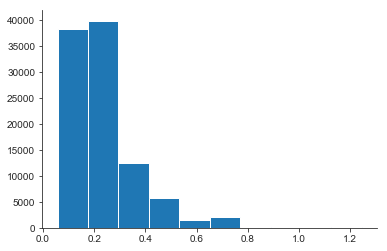

In [91]:
plt.hist(gt_);

### Test 2

In [172]:
var = tfd.Poisson(tf.exp(tf.gather(gamma_true, count_table['genes']))).sample(1)
with tf.Session() as sess:
    v = sess.run(var)

In [181]:
v

array([[  1.,   2.,   1.,   1.,   1.,   1.,   2.,   2., 394., 376., 440.,
        395., 384., 404., 423., 420.]])

In [188]:
tf.reset_default_graph()

In [189]:
def easy_model(count_table, len_g):
    gamma_tau = ed.InverseGamma(5., 1., name="gamma_tau")
    gamma = ed.Normal(tf.zeros(len_g), gamma_tau, name="gamma")   
    x = ed.Poisson(tf.exp(tf.gather(gamma, count_table['genes'])), name="x")
    return x

log_joint = ed.make_log_joint_fn(easy_model)

In [190]:
def target_log_prob_fn(gamma_tau, gamma):
    return log_joint(
        count_table=count_table, 
        len_g=2,
        gamma_tau=gamma_tau,
        gamma=gamma,        
        x=v[0])

In [191]:
num_results = int(10e3)
num_burnin_steps = int(1e3)

step_size = tf.get_variable(name='step_size', initializer=1., use_resource=True)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros(2, name='gamma')
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=1000),
        num_leapfrog_steps=5));

In [192]:
gt_, g_ = states

In [193]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    init_op.run()
    gt, g, is_accepted_ = sess.run([gt_, g_, kernel_results.is_accepted])

In [194]:
gamma_true

array([0.6, 6. ])

In [203]:
np.mean(g[:,0])

0.25671744

## Test 3

In [300]:
gamma_true

array([0.6, 6. ])

In [301]:
beta_true

array([0.52582267, 0.62127506, 6.0186158 , 6.06741494])

In [302]:
var = tfd.Poisson(tf.exp(tf.gather(beta_true, count_table['conditions']))).sample(1)
with tf.Session() as sess:
    v = sess.run(var)

In [303]:
beta_true

array([0.52582267, 0.62127506, 6.0186158 , 6.06741494])

In [338]:
def easy_model(count_table, len_g, len_beta, len_l):
    gamma_tau = ed.InverseGamma(1, 1, name="gamma_tau")
    gamma = ed.Normal(tf.zeros(len_g), gamma_tau, name="gamma")
    
    beta_tau = ed.InverseGamma(1, 1, name="beta_tau")
    beta = ed.Normal(tf.gather(gamma, np.array([0, 0, 1, 1])),
                     beta_tau, name="beta")
    beta_f = tf.gather(beta, count_table['conditions'])
    x = ed.Poisson(tf.exp(beta_f), name="x")
    return x

log_joint = ed.make_log_joint_fn(easy_model)

In [339]:
def target_log_prob_fn(gamma_tau, gamma, beta_tau, beta):
    return log_joint(
        count_table=count_table, 
        len_g=2, len_beta=4, len_l=8,
        gamma_tau=gamma_tau,
        gamma=gamma,
        beta_tau=beta_tau,
        beta=beta,
        x=v[0])

In [340]:
tf.reset_default_graph()

In [341]:
num_results = int(10e3)
num_burnin_steps = int(10e3)

step_size = tf.get_variable(name='step_size', initializer=1., use_resource=True)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros(2, name='gamma'),
        tf.ones([], name='beta_tau'),
        tf.zeros(4, name='beta')
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=1000),
        num_leapfrog_steps=5)
    );

In [342]:
_, gamma_, _, beta_f_  = states

In [343]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    init_op.run()
    gamma_, beta_f_, is_accepted_ = sess.run([gamma_, beta_f_, kernel_results.is_accepted])

In [346]:
np.mean(beta_f_, 0)

array([0.29491165, 0.67291135, 5.9871955 , 6.1256948 ], dtype=float32)

In [345]:
np.mean(gamma_, 0)

array([0.5349346, 5.9255295], dtype=float32)

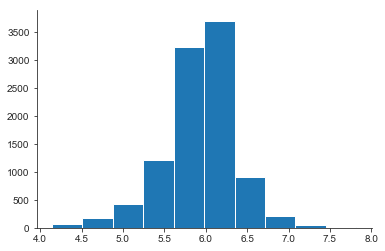

In [356]:
plt.hist(gamma_[:,1]);

In [347]:
beta_true

array([0.52582267, 0.62127506, 6.0186158 , 6.06741494])

In [348]:
gamma_true

array([0.6, 6. ])

In [353]:
ps = tfp.mcmc.potential_scale_reduction(beta_)
with tf.Session() as sess:
    ps_ = sess.run(ps)

In [354]:
ps_

5.4635587

## Test 4

In [387]:
var = tfd.Poisson(tf.exp(tf.gather(beta_true, count_table['conditions']) + 
                         tf.gather(l_true, count_table['sgrnas']))).sample(1)
with tf.Session() as sess:
    v = sess.run(var)

In [388]:
v

array([[  2.,   1.,   2.,   3.,   1.,   2.,   0.,   2., 350., 364., 478.,
        421., 488., 480., 465., 408.]])

In [390]:
def easy_model(count_table, len_g, len_beta, len_l):
    gamma_tau = ed.InverseGamma(1, 1, name="gamma_tau")
    gamma = ed.Normal(tf.zeros(len_g), gamma_tau, name="gamma")
    
    beta_tau = ed.InverseGamma(1, 1, name="beta_tau")
    beta = ed.Normal(tf.gather(gamma, np.array([0, 0, 1, 1])),
                     beta_tau, name="beta")
    beta_f = tf.gather(beta, count_table['conditions'])
    
    l = ed.Normal(tf.zeros(len_l), .1, name="l")    
    le = tf.gather(l, count_table['sgrnas'])
    
    x = ed.Poisson(le + tf.exp(beta_f), name="x")
    return x

log_joint = ed.make_log_joint_fn(easy_model)

In [391]:
def target_log_prob_fn(gamma_tau, gamma, beta_tau, beta, l):
    return log_joint(
        count_table=count_table, 
        len_g=2, len_beta=4, len_l=8,
        gamma_tau=gamma_tau,
        gamma=gamma,
        beta_tau=beta_tau,
        beta=beta,
        l=l,
        x=v[0])

In [393]:
tf.reset_default_graph

num_results = int(10e3)
num_burnin_steps = int(10e3)

step_size = tf.get_variable(name='step_size', initializer=1., use_resource=True)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros(2, name='gamma'),
        tf.ones([], name='beta_tau'),
        tf.zeros(4, name='beta'),
        tf.zeros(8, name='l')
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=1000),
        num_leapfrog_steps=5)
    );

In [394]:
_, gamma_, _, beta_f_, l_  = states

In [395]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    init_op.run()
    gamma_, beta_f_, l_, is_accepted_ = sess.run([gamma_, beta_f_, l_, kernel_results.is_accepted])

In [396]:
beta_true

array([0.52582267, 0.62127506, 6.0186158 , 6.06741494])

In [397]:
np.mean(beta_f_, 0)

array([0.5883136 , 0.28950652, 5.9987693 , 6.1308713 ], dtype=float32)

In [398]:
gamma_true

array([0.6, 6. ])

In [399]:
np.mean(gamma_, 0)

array([0.53385913, 5.852625  ], dtype=float32)

In [400]:
l_true

array([ 0.33722963, -0.09203908, -0.03986384, -0.00608641, -0.14187505,
        0.10424916,  0.09035325,  0.00190003])

In [401]:
np.mean(l_, 0)

array([-0.00195797,  0.01101431,  0.00306771, -0.0040696 , -0.00059212,
        0.00162464,  0.00212914,  0.00116956], dtype=float32)

## Test 5

In [120]:
s = tfd.Bernoulli(probs=.5).sample(100)
with tf.Session() as sess:
    s = sess.run(s)
    print(s)

[1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0
 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1
 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1]


In [25]:
var = tfd.Poisson(tf.exp(tf.gather(beta_true, count_table['conditions']) + 
                         tf.gather(l_true, count_table['sgrnas']))).sample(1)
with tf.Session() as sess:
    v = sess.run(var)

In [155]:
def shm(count_table, len_g, len_beta, len_l):
    p = ed.Uniform(0., 1., name="p")
    category = ed.Bernoulli(probs=tf.ones(len_g) * p, name="category")
    
    gamma_tau = ed.InverseGamma(5, 1, name="gamma_tau")    
    gamma = ed.Normal(tf.constant([-1. , 1.]), gamma_tau, name="gamma")
        
    beta_tau = ed.InverseGamma(5, 1, name="beta_tau")
    beta = ed.Normal(tf.gather(gamma, np.array([0, 0, 1, 1])),
                     beta_tau, name="beta")
    beta_f = tf.gather(beta, count_table['conditions'])
    
    l = ed.Normal(tf.zeros(len_l), .1, name="l")    
    le = tf.gather(l, count_table['sgrnas'])
    
    x = ed.Poisson(le + tf.exp(beta_f), name="x")
    return x

log_joint = ed.make_log_joint_fn(shm)
def target_log_prob_fn(p, category, gamma_tau, gamma, beta_tau, beta, l):
    return log_joint(
        count_table=count_table, 
        len_g=2, len_beta=4, len_l=8,
        p=p,
        category=category,        
        gamma_tau=gamma_tau,
        gamma=gamma,
        beta_tau=beta_tau,
        beta=beta,
        l=l,
        x=v[0])

In [167]:
tf.reset_default_graph()

num_results = int(10e5)
num_burnin_steps = int(10e5)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='p'),
        tf.ones(2, name='category'),                
        tf.ones([], name='gamma_tau'),        
        tf.zeros(2, name='gamma'),
        tf.ones([], name='beta_tau'),
        tf.zeros(4, name='beta'),
        tf.zeros(8, name='l')
    ],
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=target_log_prob_fn)
    );

/home/simon/miniconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [163]:
p_, category_, gamma_tau_, gamma_, beta_tau_, beta_, l_ = states

In [168]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    init_op.run()
    [
        states, is_accepted_
    ] = sess.run([
        states, kernel_results.is_accepted
    ])

In [169]:
states

[array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), array([[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]